In [1]:
import tensorflow as tf
import scipy.io.wavfile as wav
import numpy as np
import os
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
class PlanarVAE(tf.keras.Model):
    """Planar Variational Autoencoder."""

    def __init__(self, latent_dim, input_shape_):
        super(PlanarVAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_shape_ = input_shape_

        # Encoder
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=input_shape_),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(latent_dim + latent_dim)  # mean and log variance
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(np.prod(input_shape_), activation=None),
            tf.keras.layers.Reshape(target_shape=input_shape_)
        ])

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        logits = self.decode(z)
        return logits

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        batch_size = tf.shape(mean)[0]
        eps = tf.random.normal(shape=(batch_size, self.latent_dim))
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        logits = self.decoder(z)
        return logits

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps)

In [4]:
subsample_factor = 4
# Load the time series from .npy files
def load_data_from_folder(folder_path, subsample_factor=1):
    data = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.npy'):
            file_path = os.path.join(folder_path, file_name)
            time_series = np.load(file_path)
            subsampled_time_series = time_series[::subsample_factor]
            data.append(subsampled_time_series)
    return np.array(data)

In [5]:
# Load data
folder_path = 'drive/MyDrive/music_preprocessed_planarVAE'
data = load_data_from_folder(folder_path, subsample_factor=subsample_factor)

In [6]:
# Normalize data (assuming data is between 0 and 1; adjust if needed)
data = data.astype(np.float32) / np.max(data)

# Create TensorFlow dataset
batch_size = 16
dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.shuffle(buffer_size=len(data)).batch(batch_size)

In [7]:
# Setup
latent_dim = 16  # Adjust as needed
input_shape_ = ((44100*5) // subsample_factor,)  # Adjusted input shape for 5 seconds at 44100 Hz
print(f"input shape:{input_shape_}")

model = PlanarVAE(latent_dim, input_shape_)
optimizer = tf.keras.optimizers.Adam(1e-4)
model.build((None, *input_shape_))  # Build the model with input shape
model.summary()

input shape:(55125,)
Model: "planar_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32)                14149280  
                                                                 
 sequential_1 (Sequential)   (None, 55125)             14202325  
                                                                 
Total params: 28351605 (108.15 MB)
Trainable params: 28351605 (108.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
# Ensure data shape matches the model's input shape
data = data[:, :input_shape_[0]]

# Create a TensorFlow dataset
batch_size = 16
dataset = tf.data.Dataset.from_tensor_slices(data).batch(batch_size)

def log_normal_pdf(sample, mean, logvar, raxis=1):        # function that defines a lognormal function
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
    # Encode input to obtain mean and log variance
    mean, logvar = model.encode(x)
    # Reparameterize to get latent variable z
    z = model.reparameterize(mean, logvar)
    # Decode to get the reconstruction
    x_logit = model.decode(z)

    # Compute reconstruction loss (Mean Squared Error)
    mse_loss = tf.reduce_mean(tf.square(x - x_logit), axis=-1)  # Reduce over the feature dimension

    # Compute KL divergence
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    kl_divergence = logqz_x - logpz

    # Total loss: reconstruction error - KL divergence
    loss = tf.reduce_mean(mse_loss - kl_divergence)
    return loss

@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.build(model.trainable_variables)

In [9]:
def generate_and_save_audio(model, epoch, output_dir='drive/MyDrive/generated_audio', subsample_factor=1):
    os.makedirs(output_dir, exist_ok=True)

    # Compute current sampling rate
    base_sampling_rate = 44100  # Example base rate
    sampling_rate = base_sampling_rate // subsample_factor

    # Generate samples from the latent space
    num_samples = 1
    latent_samples = tf.random.normal(shape=(num_samples, model.latent_dim))
    generated_audio = model.decode(latent_samples)  # Generate audio from latent space

    # Convert the generated audio to numpy array
    generated_audio_np = generated_audio.numpy()
    generated_audio_np = np.clip(generated_audio_np, -1.0, 1.0)

    for i, audio in enumerate(generated_audio_np):
        file_path = os.path.join(output_dir, f'audio_epoch_{epoch}_sample_{i}.wav')
        wav.write(file_path, sampling_rate, (audio * 32767).astype(np.int16))

In [10]:
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 16
num_examples_to_generate = 1

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = PlanarVAE(latent_dim, input_shape_)

In [11]:
from IPython.display import display, clear_output

# Training loop
epochs = 25

loss_history = []

for epoch in range(1, epochs + 1):
    start_time = time.time()

    # Training
    for batch in dataset:
        train_step(model, batch, optimizer)

    end_time = time.time()

    # Compute loss for the dataset
    loss_metric = tf.keras.metrics.Mean()
    for batch in dataset:
        loss_metric(compute_loss(model, batch))
    elbo = -loss_metric.result()

    # Save the loss value for the current epoch
    loss_history.append(elbo.numpy())

    # Print status
    clear_output(wait=False)  # Clear output for each epoch
    print(f'Epoch: {epoch}, Test set ELBO: {elbo:.4f}, Time elapsed for current epoch: {end_time - start_time:.2f} seconds')

    # Generate and save audio files
    generate_and_save_audio(model, epoch, subsample_factor=subsample_factor)

Epoch: 25, Test set ELBO: 0.2924, Time elapsed for current epoch: 0.30 seconds


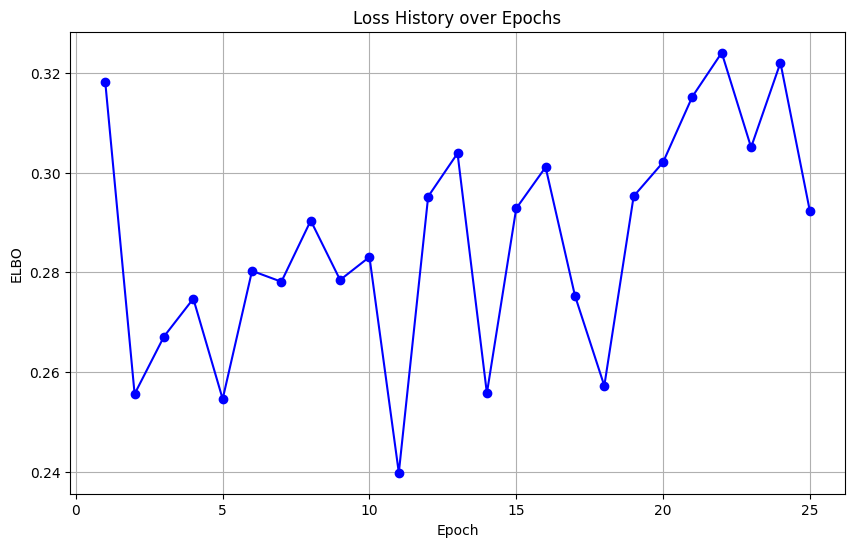

In [12]:
import matplotlib.pyplot as plt
# Plot loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), loss_history, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('ELBO')
plt.title('Loss History over Epochs')
plt.grid(True)
plt.show()

In [13]:
# Define input shape
input_shape = (None, np.prod(data.shape[1:]))

# Build the model
model.build(input_shape)
print("Model built.")

dummy_input = tf.random.normal(shape=(1, np.prod(data.shape[1:])))  # Batch size of 1
model(dummy_input)  # This call will build the model

# Save the trained model
model_save_path = 'drive/MyDrive/trained_planar_vae'
model.save(model_save_path)
print(f"Model saved to {model_save_path}.")

Model built.
Model saved to drive/MyDrive/trained_planar_vae.
Model saved to drive/MyDrive/trained_planar_vae.
